<a href="https://colab.research.google.com/github/luthierman/quantum-research-colab/blob/main/quantum_initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
!pip install wandb

     |████████████████████████████████| 914 kB 30.7 MB/s 
     |████████████████████████████████| 8.8 MB 51.0 MB/s 
     |████████████████████████████████| 1.6 MB 30.2 MB/s 
     |████████████████████████████████| 108 kB 64.8 MB/s 
     |████████████████████████████████| 1.8 MB 26.5 MB/s 
     |████████████████████████████████| 181 kB 60.4 MB/s 
     |████████████████████████████████| 144 kB 68.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b0a1e3ced2f690b3f1c4009e28e934da92352588688570f20c119be60e13bb20
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [19]:
# %%writefile identity_block.py
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from pennylane import numpy as np 
import random
import torch


L = 1
M = 2
n = 4
dev = qml.device("default.qubit", wires=n)
def initialize(n,L,M):
  parameters = np.zeros((M,2*L,n))
  
  for m in range(M):
    stack = []
    for l in range(L):
      for i in range(n):
        theta = np.random.uniform(0,2*np.pi)
        stack.append(theta)
        parameters[m,l,i] = theta
    for l in range(L,2*L):
      for i in range(n):
        parameters[m,l,n-i-1] = stack.pop()
  return qml.math.concatenate(parameters)
thetas = initialize(n,L,M)
def block(parameters,n, L, M):
  U_m = []
  ops = [qml.RX, qml.RY, qml.RZ]
  for l in range(L):
    for i in range(n):
      U = random.choice(ops)
      U_m.append(U)
      U(parameters[l,i], wires=i)
    for i in range(n-1):
      qml.CZ(wires=[(i)%n,(i+1)%n])
  for l in range(L, 2*L):
    for i in range(n-1):
      qml.CZ(wires=[n-i-2,n-i-1])
    for i in range(n):
      U = U_m.pop()
      U(parameters[l,n-i-1], wires=n-i-1).inv()
@qml.qnode(dev, interface='torch')
def circuit(inputs, weights):
  qml.AngleEmbedding(inputs*(np.pi/4), 
                     wires = range(n),
                     rotation="Y")
  for i in range(0,2*M*L,2*L):
    block(weights[i:i+2*L],n, L, M)
  
  # qml.CNOT(wires=[0,2])
  # qml.CNOT(wires=[1,3])
  return [qml.expval(qml.PauliY(ind)) for ind in range(4)]

class IBS(nn.Module):
    def __init__(self, thetas, use_cuda=False):
        super(IBS, self).__init__()
        if use_cuda and not torch.cuda.is_available():
            raise Exception("Asked for CUDA but GPU not found")
            
        self.use_cuda = use_cuda
        weight_shapes = {"weights": thetas.shape}
        self.circuit = circuit
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)#.to('cuda' if use_cuda else 'cpu')
        self.linear1 = nn.Linear(n, 2)#.to('cuda' if use_cuda else 'cpu')
        nn.init.xavier_normal_(self.linear1.weight)
        self.linear1.bias.data.zero_()
        new_state_dict = self.qlayer.state_dict()
        new_state_dict['weights'] = torch.tensor(thetas)
        self.qlayer.load_state_dict(new_state_dict)
        self.thetas = self.qlayer.state_dict()
        self.print_circuit()

    def forward(self, x):
        x = torch.tensor(x)
        x = x.float()#.to('cuda' if self.use_cuda else 'cpu')
        x.requires_grad = True
        x = self.qlayer(x)
        return x.float()

    def print_circuit(self):
        self.thetas = self.qlayer.state_dict()["weights"]
        drawer = qml.draw(self.circuit, show_all_wires=True)(torch.tensor([0,0,0,0]),
                                        self.thetas)
        print(drawer)

    def print_circuit_mpl(self):
        self.thetas = self.qlayer.state_dict()["weights"]
        qml.drawer.use_style("black_white_dark")

        drawer = qml.draw_mpl(self.circuit,fontsize="xx-large", expansion_strategy="device")(torch.tensor([0,0,0,0]),
                                        self.thetas)
        return drawer
c = IBS(thetas)  

0: ─╭AngleEmbedding(M0)──RZ(5.50)─╭C──────────────────────╭C───────────RZ⁻¹(5.50)──RX(0.88)─╭C──────
1: ─├AngleEmbedding(M0)──RZ(0.23)─╰Z─╭C───────╭C──────────╰Z───────────RZ⁻¹(0.23)──RZ(1.19)─╰Z─╭C───
2: ─├AngleEmbedding(M0)──RY(0.02)────╰Z─╭C─╭C─╰Z───────────RY⁻¹(0.02)──RX(3.55)────────────────╰Z─╭C
3: ─╰AngleEmbedding(M0)──RZ(3.67)───────╰Z─╰Z──RZ⁻¹(3.67)──RX(1.64)───────────────────────────────╰Z

─────────────────╭C───────────RX⁻¹(0.88)─┤  <Y>
─────╭C──────────╰Z───────────RZ⁻¹(1.19)─┤  <Y>
──╭C─╰Z───────────RX⁻¹(3.55)─────────────┤  <Y>
──╰Z──RX⁻¹(1.64)─────────────────────────┤  <Y>


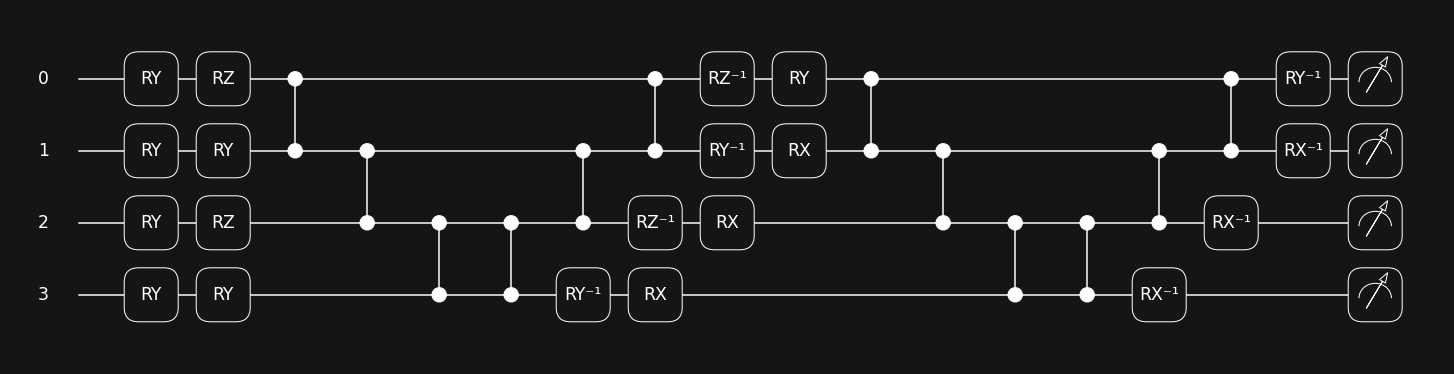

In [21]:
fig, ax = c.print_circuit_mpl()
fig.savefig("f.png")

In [ ]:
from collections import namedtuple,deque
import random
import numpy as np
import pandas as pd
import torch 
class ER_Memory(object):
    def __init__(self, length):
        
        
        self.memory = deque(maxlen=length)
    def remember(self, *args):
        self.memory.append([*args])

    def sample(self, batch_size):
        minibatch = np.stack(random.sample(self.memory, batch_size))
        return minibatch

    def __len__(self):
      return len(self.memory)
    def show(self):
      return pd.DataFrame(self.memory)

In [ ]:
LR = 0.00025
GAMMA = 0.95
EPSILON = 1.0
EPSILON_DECAY= 0.9999
EPSILON_MIN = 0.01
N_EPISODES = 200
BATCH_SIZE = 64
UPDATE_TARGET = 10
BUFF = 100000
TRAIN_START = 1

In [ ]:
import gym
import matplotlib.pyplot as plt
from torch.optim import *
import torch
from collections import deque
import random
import numpy as np
import os
import time
import datetime

class QDQN(object):
    def __init__(self, env, Q_net) -> None:
        # GYM environment
        self.env = env 
        
        # HYPERPARAMETERS
        self.lr = LR
        self.gamma = GAMMA
        self.epsilon = EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_min = EPSILON_MIN
        self.batch = BATCH_SIZE
        self.episodes = N_EPISODES
        self.update_target = UPDATE_TARGET
        self.train_start = TRAIN_START
        self.buff = BUFF
        # Q-network and Target-network
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = Q_net
        self.opt = Adam(self.q_network.parameters(), lr=self.lr)
        self.target = Q_net
        self.sync_weights()
        if use_cuda:
            print("GPU being used:", torch.cuda.get_device_name(0))
            self.q_network.cuda(self.device)
            self.target.cuda(self.device)
        self.target.eval()
        self.loss_fn = torch.nn.MSELoss()

        # DQN setup
        self.memory = ER_Memory(self.buff)
        self.counter = 0
        self.step = 0
        self.current_episode = 0
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.opt, 'min')
        # stat tracking
        self.rewards = []
        self.losses = []
        self.accuracies = []
        self.q_values = []
        self.no_steps = []
        self.avg = 0
        self.total_reward = 0
        self.avg_reward = deque(maxlen=self.episodes)
        self.rs = deque(maxlen=50)
        self.lrs = []

        # save model
        self.log_path = os.getcwd() + "\logs"
        self.name = "DQN_Dense_{}".format(datetime.datetime.now())

    def preprocess_state(self, x):
        state = np.stack(x)
        state = torch.from_numpy(state).float().to(self.device)
        return state

    def run_episode(self):
        s1 = self.env.reset()
        steps = 0
        done = False
        self.total_reward = 0
        total_loss = 0
        total_q = 0
        while not done:
            action = self.get_action(s1)
            s2, reward, done, _ = self.env.step(action)
            self.total_reward += reward
            self.remember(s1,
                          action,
                          reward,
                          s2,
                          done)
            if done:

                self.rewards.append(self.total_reward),
                self.losses.append(total_loss),
                self.rs.append(self.total_reward)
                self.avg = np.mean(self.rs)
                self.avg_reward.append(self.avg)
                self.q_values.append(total_q/steps)
                self.no_steps.append(steps)
                self.current_episode+=1
                break
            s1 = s2
            if self.counter > self.train_start:
              loss, q = self.learn()
              if loss != None:
                  total_loss += loss
                  total_q += q.detach().cpu().mean()
            steps += 1
            if steps % self.update_target == 0:
                self.sync_weights()

    def learn(self):
        if len(self.memory) < self.train_start:
            return 0

        minibatch = self.memory.sample(min(len(self.memory), self.batch))
        states = self.preprocess_state(minibatch[:, 0])
        actions = self.preprocess_state(minibatch[:, 1]).type(torch.int64).unsqueeze(-1)
        rewards = self.preprocess_state(minibatch[:, 2])
        next_states = self.preprocess_state(minibatch[:, 3])
        dones = self.preprocess_state(minibatch[:, 4])
        # DQN

        self.q_network.train()
        self.target.eval()
        # Q
        Q = self.q_network.forward(states).gather(1, actions).squeeze(-1)  # Q(s, a, wq)
        # target
        Q_next = self.target.forward(next_states).max(1)[0].detach()  # max _a Q(ns, a, wt)
        y = rewards + self.gamma * (1 - dones) * Q_next  # bellman
        self.opt.zero_grad()
        loss = self.cost_fn(y, Q)
        loss.backward()
        self.opt.step()
        # self.scheduler.step(loss)
        return loss.item(), Q
    def cost_fn(self, y,Q):
        cost = 0
        for i, v in enumerate(y):
          cost+= torch.mean((v-Q[i])**2)
        return cost
    def sync_weights(self):
        self.target.load_state_dict(self.q_network.state_dict())

    def get_action(self, obs):
        if len(self.memory) > self.batch:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        if np.random.random() <= self.epsilon:
            return self.env.action_space.sample()
        else:
            self.q_network.eval()
            obs = self.preprocess_state([obs])
            return self.q_network(obs).argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.remember(state, action, reward, next_state, done)
        self.counter += 1


torch.cuda.empty_cache()
env = gym.make("CartPole-v0")
qnet = IBS(thetas,True)
agent_dqn = QDQN(env, IBS(thetas,True))
print(agent_dqn.name)
for i in range(agent_dqn.episodes):
    agent_dqn.run_episode()
    print("\rEpisode {}/{} || Current Avg {}, Episode Reward {}, Loss {}, Q {}, Steps {}, eps {}".format(
        agent_dqn.current_episode,
        agent_dqn.episodes,
        np.round(agent_dqn.avg, 3),
        np.round(agent_dqn.total_reward, 3),
        np.round(agent_dqn.losses[i], 3),
        np.round(agent_dqn.q_values[i], 3),
        agent_dqn.no_steps[i],
        np.round(agent_dqn.epsilon, 3)
    ),flush=True, end="")




0: ─╭AngleEmbedding(M0)──RY(2.24)─╭C──RY(6.24)───────────╭C─────────────────────────────╭C─────────
1: ─├AngleEmbedding(M0)──RY(4.93)─╰Z─╭C─────────RX(2.69)─╰Z────────╭C───────╭C──────────╰Z─────────
2: ─├AngleEmbedding(M0)──RX(4.77)────╰Z────────╭C─────────RX(0.55)─╰Z─╭C─╭C─╰Z───────────RX⁻¹(0.55)
3: ─╰AngleEmbedding(M0)──RZ(0.46)──────────────╰Z─────────RY(4.85)────╰Z─╰Z──RY⁻¹(4.85)────────────

───RY⁻¹(6.24)─────────────╭C───────────RY⁻¹(2.24)──RX(2.70)─╭C──RX(3.95)───────────╭C─────────────
───RX⁻¹(2.69)─╭C──────────╰Z───────────RY⁻¹(4.93)──RZ(0.28)─╰Z─╭C─────────RY(0.67)─╰Z────────╭C───
──╭C──────────╰Z───────────RX⁻¹(4.77)──RY(4.25)────────────────╰Z────────╭C─────────RY(2.02)─╰Z─╭C
──╰Z───────────RZ⁻¹(0.46)──RX(3.74)──────────────────────────────────────╰Z─────────RZ(4.72)────╰Z

─────────────────╭C───────────RX⁻¹(3.95)─────────────╭C───────────RX⁻¹(2.70)─╭C────┤     
─────╭C──────────╰Z───────────RY⁻¹(0.67)─╭C──────────╰Z───────────RZ⁻¹(0.28)─│──╭C─┤     
──╭C─╰Z───────────RY⁻¹

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 22/200 || Current Avg 23.273, Episode Reward 9.0, Loss 608.333, Q 0.17499999701976776, Steps 8, eps 0.956

KeyboardInterrupt: ignored